# Customer Feature Engineering

This notebook implements customer feature engineering for the H&M dataset, including:

- RFM Analysis (Recency, Frequency, Monetary)
- Purchase diversity score
- Price sensitivity index
- Colour preference entropy
- Style consistency score

The engineered features will later be used for customer segmentation and behavioural analysis.


## 1. Setup and Imports


In [1]:
# Add project root to path
import sys
sys.path.append('../')

# Core imports
import polars as pl
import numpy as np
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Visualisation imports
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Project imports
from hnm_data_analysis.feature_engineering.customer_features import CustomerFeatures
from hnm_data_analysis.data_understanding.data_report_generator import generate_data_report

# Configuration
plt.style.use('seaborn-v0_8')
pl.Config.set_tbl_rows(10)
pl.Config.set_tbl_cols(15)

print("Setup complete!")
print(f"Polars version: {pl.__version__}")
print(f"Working directory: {Path.cwd()}")

Setup complete!
Polars version: 1.32.2
Working directory: c:\Users\tom\coding_projects\data_analytics_projects\h_and_m_data_analysis\notebooks


## 2. Data Loading and Initial Exploration

Let's examine the structure of our cleaned datasets before feature engineering.


In [2]:
# Load cleaned datasets for exploration
customers_path = "../data/cleaned/customers_cleaned.parquet"
transactions_path = "../data/cleaned/transactions_cleaned.parquet"
articles_path = "../data/features/final/articles_features_final.parquet"

# Check file existence
for path in [customers_path, transactions_path, articles_path]:
    if not Path(path).exists():
        print(f"‚ö†Ô∏è  Warning: {path} not found")
    else:
        print(f"‚úÖ {path} found")

print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)

‚úÖ ../data/cleaned/customers_cleaned.parquet found
‚úÖ ../data/cleaned/transactions_cleaned.parquet found
‚úÖ ../data/features/final/articles_features_final.parquet found

DATASET OVERVIEW


In [3]:
# Load and examine customers data
customers_df = pl.read_parquet(customers_path)

print("üìä CUSTOMERS DATASET")
print(f"Shape: {customers_df.shape}")
print(f"Columns: {list(customers_df.columns)}")
print("\nSchema:")
print(customers_df.schema)
print("\nSample data:")
customers_df.head(3)

üìä CUSTOMERS DATASET
Shape: (525075, 14)
Columns: ['customer_id', 'FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'FN_imputed', 'Active_imputed', 'club_member_status_imputed', 'fashion_news_frequency_imputed', 'age_imputed', 'postal_code_imputed', 'age_corrected']

Schema:
Schema([('customer_id', String), ('FN', Float64), ('Active', Float64), ('club_member_status', Categorical(Categories(""))), ('fashion_news_frequency', Categorical(Categories(""))), ('age', Float64), ('postal_code', Categorical(Categories(""))), ('FN_imputed', Boolean), ('Active_imputed', Boolean), ('club_member_status_imputed', Boolean), ('fashion_news_frequency_imputed', Boolean), ('age_imputed', Boolean), ('postal_code_imputed', Boolean), ('age_corrected', Boolean)])

Sample data:


shape: (3, 14)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ cus ‚îÜ FN  ‚îÜ Act ‚îÜ clu ‚îÜ fas ‚îÜ age ‚îÜ pos ‚îÜ FN_imp ‚îÜ Activ ‚îÜ club_ ‚îÜ fashi ‚îÜ age_i ‚îÜ posta ‚îÜ age_c ‚îÇ
‚îÇ tom ‚îÜ --- ‚îÜ ive ‚îÜ b_m ‚îÜ hio ‚îÜ --- ‚îÜ tal ‚îÜ uted   ‚îÜ e_imp ‚îÜ membe ‚îÜ on_ne ‚îÜ mpute ‚îÜ l_cod ‚îÜ orrec ‚îÇ
‚îÇ er_ ‚îÜ f64 ‚îÜ --- ‚îÜ emb ‚îÜ n_n ‚îÜ f64 ‚îÜ _co ‚îÜ ---    ‚îÜ uted  ‚îÜ r_sta ‚îÜ ws_fr ‚îÜ d     ‚îÜ e_imp ‚îÜ ted   ‚îÇ
‚îÇ id  ‚îÜ     ‚îÜ f64 ‚îÜ er_ ‚îÜ ews ‚îÜ     ‚îÜ de  ‚îÜ bool   ‚îÜ ---   ‚îÜ tus_i ‚îÜ equen ‚îÜ ---   ‚îÜ uted  ‚îÜ ---   ‚îÇ
‚îÇ --- ‚îÜ     ‚îÜ     ‚îÜ sta ‚îÜ _fr ‚îÜ     ‚îÜ --- ‚îÜ        ‚îÜ bool  ‚îÜ mpute ‚îÜ cy_im ‚îÜ bool  ‚îÜ ---   ‚îÜ bool  ‚îÇ
‚îÇ str ‚îÜ     ‚îÜ     ‚îÜ tus ‚îÜ equ ‚îÜ     ‚îÜ cat ‚îÜ        ‚îÜ       ‚îÜ d     ‚îÜ puted ‚îÜ       ‚îÜ bool  ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ --- ‚îÜ enc ‚îÜ     ‚îÜ     ‚îÜ        ‚îÜ       ‚îÜ ---   ‚îÜ ---   ‚îÜ       ‚îÜ       ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ cat ‚îÜ y   ‚îÜ     ‚îÜ     ‚îÜ        ‚îÜ       ‚îÜ bool  ‚îÜ bool  ‚îÜ       ‚îÜ       ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ --- ‚îÜ     ‚îÜ     ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ cat ‚îÜ     ‚îÜ     ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 987 ‚îÜ 0.0 ‚îÜ 0.0 ‚îÜ ACT ‚îÜ NON ‚îÜ 53. ‚îÜ ab7 ‚îÜ true   ‚îÜ true  ‚îÜ false ‚îÜ false ‚îÜ false ‚îÜ false ‚îÜ false ‚îÇ
‚îÇ a06 ‚îÜ     ‚îÜ     ‚îÜ IVE ‚îÜ E   ‚îÜ 0   ‚îÜ bb5 ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÇ
‚îÇ 36e ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ 609 ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÇ
‚îÇ e7a ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ 5a3 ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÇ
‚îÇ 65d ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ 26a ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÇ
‚îÇ 368 ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ f77 ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÇ
‚îÇ 535 ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ d6a ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÇ
‚îÇ 448 ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ 661 ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÇ
‚îÇ 00e ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ d9c ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÇ
‚îÇ b36 ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ cb0 ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÇ
‚îÇ ‚Ä¶   ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ ‚Ä¶   ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÇ
‚îÇ 63a ‚îÜ 0.0 ‚îÜ 0.0 ‚îÜ PRE ‚îÜ NON ‚îÜ 30. ‚îÜ ab0 ‚îÜ true   ‚îÜ true  ‚îÜ false ‚îÜ false ‚îÜ true  ‚îÜ false ‚îÜ false ‚îÇ
‚îÇ 5d9 ‚îÜ     ‚îÜ     ‚îÜ -CR ‚îÜ E   ‚îÜ 0   ‚îÜ 0a4 ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÇ
‚îÇ 387 ‚îÜ     ‚îÜ     ‚îÜ EAT ‚îÜ     ‚îÜ     ‚îÜ 6bb ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÇ
‚îÇ 574 ‚îÜ     ‚îÜ     ‚îÜ E   ‚îÜ     ‚îÜ     ‚îÜ e81 ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÇ
‚îÇ 0a0 ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ d6a ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ    

In [4]:
# Load and examine transactions data
transactions_df = pl.read_parquet(transactions_path)

print("üìä TRANSACTIONS DATASET")
print(f"Shape: {transactions_df.shape}")
print(f"Columns: {list(transactions_df.columns)}")
print("\nSchema:")
print(transactions_df.schema)
print("\nDate range:")
print(transactions_df.select([pl.col("t_dat").min().alias("min_date"), 
                             pl.col("t_dat").max().alias("max_date")]))
print("\nSample data:")
transactions_df.head(3)

üìä TRANSACTIONS DATASET
Shape: (3904391, 8)
Columns: ['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id', 'price_outlier_capped', 'sales_channel_corrected', 'price_percentile_calibrated']

Schema:
Schema([('t_dat', Date), ('customer_id', String), ('article_id', Int64), ('price', Float64), ('sales_channel_id', Int64), ('price_outlier_capped', Boolean), ('sales_channel_corrected', Boolean), ('price_percentile_calibrated', Boolean)])

Date range:
shape: (1, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ min_date   ‚îÜ max_date   ‚îÇ
‚îÇ ---        ‚îÜ ---        ‚îÇ
‚îÇ date       ‚îÜ date       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2020-06-24 ‚îÜ 2020-09-22 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

Sample data:


shape: (3, 8)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ t_dat      ‚îÜ customer_i ‚îÜ article_id ‚îÜ price ‚îÜ sales_chan ‚îÜ price_outl ‚îÜ sales_chan ‚îÜ price_perc ‚îÇ
‚îÇ ---        ‚îÜ d          ‚îÜ ---        ‚îÜ ---   ‚îÜ nel_id     ‚îÜ ier_capped ‚îÜ nel_correc ‚îÜ entile_cal ‚îÇ
‚îÇ date       ‚îÜ ---        ‚îÜ i64        ‚îÜ f64   ‚îÜ ---        ‚îÜ ---        ‚îÜ ted        ‚îÜ ibrated    ‚îÇ
‚îÇ            ‚îÜ str        ‚îÜ            ‚îÜ       ‚îÜ i64        ‚îÜ bool       ‚îÜ ---        ‚îÜ ---        ‚îÇ
‚îÇ            ‚îÜ            ‚îÜ            ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ bool       ‚îÜ bool       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2020-06-24 ‚îÜ 0001b0127d ‚îÜ 844409002  ‚îÜ 14.33 ‚îÜ 1          ‚îÜ false      ‚îÜ false      ‚îÜ true       ‚îÇ
‚îÇ            ‚îÜ 3e5ff8dadc ‚îÜ            ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÇ
‚îÇ            ‚îÜ fc6e504368 ‚îÜ            ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÇ
‚îÇ            ‚îÜ ‚Ä¶          ‚îÜ            ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÇ
‚îÇ 2020-06-24 ‚îÜ 0001b0127d ‚îÜ 876053003  ‚îÜ 21.35 ‚îÜ 1          ‚îÜ false      ‚îÜ false      ‚îÜ true       ‚îÇ
‚îÇ            ‚îÜ 3e5ff8dadc ‚îÜ            ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÇ
‚îÇ            ‚îÜ fc6e504368 ‚îÜ            ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÇ
‚îÇ            ‚îÜ ‚Ä¶          ‚îÜ            ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÇ
‚îÇ 2020-06-24 ‚îÜ 000493dd9f ‚îÜ 831269004  ‚îÜ 11.32 ‚îÜ 1          ‚îÜ false      ‚îÜ false      ‚îÜ true       ‚îÇ
‚îÇ            ‚îÜ c463df1acc ‚îÜ            ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÇ
‚îÇ            ‚îÜ 2081450c9e ‚îÜ            ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÇ
‚îÇ            ‚îÜ ‚Ä¶          ‚îÜ            ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [5]:
# Load and examine articles data
articles_df = pl.read_parquet(articles_path)

print("üìä ARTICLES DATASET")
print(f"Shape: {articles_df.shape}")
print(f"Columns: {list(articles_df.columns)}")
print("\nSchema:")
print(articles_df.schema)
print("\nSample data:")
articles_df.head(3)

üìä ARTICLES DATASET
Shape: (42298, 14)
Columns: ['article_id', 'product_type_name', 'product_group_name', 'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name', 'detail_desc', 'bert_cluster']

Schema:
Schema([('article_id', Int64), ('product_type_name', Categorical), ('product_group_name', Categorical), ('graphical_appearance_name', Categorical), ('colour_group_name', Categorical), ('perceived_colour_value_name', Categorical), ('perceived_colour_master_name', Categorical), ('department_name', Categorical), ('index_name', Categorical), ('index_group_name', Categorical), ('section_name', Categorical), ('garment_group_name', Categorical), ('detail_desc', Categorical), ('bert_cluster', Int32)])

Sample data:


shape: (3, 14)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ art ‚îÜ pro ‚îÜ pro ‚îÜ gra ‚îÜ col ‚îÜ per ‚îÜ per ‚îÜ depart ‚îÜ index ‚îÜ index ‚îÜ secti ‚îÜ garme ‚îÜ detai ‚îÜ bert_ ‚îÇ
‚îÇ icl ‚îÜ duc ‚îÜ duc ‚îÜ phi ‚îÜ our ‚îÜ cei ‚îÜ cei ‚îÜ ment_n ‚îÜ _name ‚îÜ _grou ‚îÜ on_na ‚îÜ nt_gr ‚îÜ l_des ‚îÜ clust ‚îÇ
‚îÇ e_i ‚îÜ t_t ‚îÜ t_g ‚îÜ cal ‚îÜ _gr ‚îÜ ved ‚îÜ ved ‚îÜ ame    ‚îÜ ---   ‚îÜ p_nam ‚îÜ me    ‚îÜ oup_n ‚îÜ c     ‚îÜ er    ‚îÇ
‚îÇ d   ‚îÜ ype ‚îÜ rou ‚îÜ _ap ‚îÜ oup ‚îÜ _co ‚îÜ _co ‚îÜ ---    ‚îÜ cat   ‚îÜ e     ‚îÜ ---   ‚îÜ ame   ‚îÜ ---   ‚îÜ ---   ‚îÇ
‚îÇ --- ‚îÜ _na ‚îÜ p_n ‚îÜ pea ‚îÜ _na ‚îÜ lou ‚îÜ lou ‚îÜ cat    ‚îÜ       ‚îÜ ---   ‚îÜ cat   ‚îÜ ---   ‚îÜ cat   ‚îÜ i32   ‚îÇ
‚îÇ i64 ‚îÜ me  ‚îÜ ame ‚îÜ ran ‚îÜ me  ‚îÜ r_v ‚îÜ r_m ‚îÜ        ‚îÜ       ‚îÜ cat   ‚îÜ       ‚îÜ cat   ‚îÜ       ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ --- ‚îÜ --- ‚îÜ ce_ ‚îÜ --- ‚îÜ alu ‚îÜ ast ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ cat ‚îÜ cat ‚îÜ nam ‚îÜ cat ‚îÜ e_n ‚îÜ er_ ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ e   ‚îÜ     ‚îÜ ame ‚îÜ nam ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ --- ‚îÜ     ‚îÜ --- ‚îÜ e   ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ cat ‚îÜ     ‚îÜ cat ‚îÜ --- ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ cat ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 816 ‚îÜ T-s ‚îÜ Gar ‚îÜ Str ‚îÜ Dar ‚îÜ Dar ‚îÜ Blu ‚îÜ Tops   ‚îÜ Divid ‚îÜ Divid ‚îÜ Divid ‚îÜ Jerse ‚îÜ T-shi ‚îÜ 22    ‚îÇ
‚îÇ 591 ‚îÜ hir ‚îÜ men ‚îÜ ipe ‚îÜ k   ‚îÜ k   ‚îÜ e   ‚îÜ Fancy  ‚îÜ ed    ‚îÜ ed    ‚îÜ ed    ‚îÜ y     ‚îÜ rt in ‚îÜ       ‚îÇ
‚îÇ 001 ‚îÜ t   ‚îÜ t   ‚îÜ     ‚îÜ Blu ‚îÜ     ‚îÜ     ‚îÜ Jersey ‚îÜ       ‚îÜ       ‚îÜ Colle ‚îÜ Fancy ‚îÜ soft  ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ Upp ‚îÜ     ‚îÜ e   ‚îÜ     ‚îÜ     ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ ction ‚îÜ       ‚îÜ cotto ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ er  ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ n jer ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ bod ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ sey ‚Ä¶ ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ y   ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÇ
‚îÇ 804 ‚îÜ Sne ‚îÜ Sho ‚îÜ Sol ‚îÜ Bla ‚îÜ Dar ‚îÜ Bla ‚îÜ Kids   ‚îÜ Child ‚îÜ Baby/ ‚îÜ Kids  ‚îÜ Shoes ‚îÜ Hi-to ‚îÜ 27    ‚îÇ
‚îÇ 472 ‚îÜ ake ‚îÜ es  ‚îÜ id  ‚îÜ ck  ‚îÜ k   ‚îÜ ck  ‚îÜ Boy    ‚îÜ ren   ‚îÜ Child ‚îÜ &     ‚îÜ       ‚îÜ ps in ‚îÜ       ‚îÇ
‚îÇ 003 ‚îÜ rs  ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ Shoes  ‚îÜ Acces ‚îÜ ren   ‚îÜ Baby  ‚îÜ       ‚îÜ patte ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ        ‚îÜ sorie ‚îÜ       ‚îÜ Shoes ‚îÜ       ‚îÜ rned  ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ        ‚îÜ s,    ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ imita ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ        ‚îÜ Swimw ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ tion‚Ä¶ ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ        ‚îÜ ear   ‚îÜ       ‚îÜ       ‚îÜ    

## 3. Customer Feature Engineering

Now we'll use our CustomerFeatures class to engineer comprehensive customer behavioural features.


In [6]:
# Configuration for feature engineering
# Set sample_size=None for full dataset processing, or specify a number for testing
SAMPLE_SIZE = None  # Change to e.g., 10000 for testing with smaller dataset
BATCH_SIZE = 50000  # Batch size for memory-efficient processing

print("üîß CUSTOMER FEATURE ENGINEERING CONFIGURATION")
print(f"Sample size: {SAMPLE_SIZE if SAMPLE_SIZE else 'Full dataset'}")
print(f"Batch size: {BATCH_SIZE}")
print("\nInitialising CustomerFeatures class...")

# Initialise feature engineer
feature_engineer = CustomerFeatures(
    customers_path=customers_path,
    transactions_path=transactions_path,
    articles_path=articles_path,
    batch_size=BATCH_SIZE,
    sample_size=SAMPLE_SIZE
)

print("‚úÖ CustomerFeatures initialised successfully!")

üîß CUSTOMER FEATURE ENGINEERING CONFIGURATION
Sample size: Full dataset
Batch size: 50000

Initialising CustomerFeatures class...
‚úÖ CustomerFeatures initialised successfully!


In [7]:
# Engineer customer features
print("üöÄ Starting customer feature engineering...")
print("This may take several minutes for the full dataset.\n")

# Create output directory
output_dir = Path("../data/features/final")
output_dir.mkdir(parents=True, exist_ok=True)

# Engineer features (this will handle all the complex calculations)
customer_features = feature_engineer.engineer_customer_features(
    output_path="../data/features/final/customer_features_final.parquet"
)

print(f"\n‚úÖ Feature engineering complete!")
print(f"Final features shape: {customer_features.shape}")
print(f"Features saved to: ../data/features/final/customer_features_final.parquet")

INFO:hnm_data_analysis.feature_engineering.customer_features:Starting customer feature engineering pipeline...
INFO:hnm_data_analysis.feature_engineering.customer_features:Loading datasets...


üöÄ Starting customer feature engineering...
This may take several minutes for the full dataset.



INFO:hnm_data_analysis.feature_engineering.customer_features:Reference date for recency: 2020-09-23
INFO:hnm_data_analysis.feature_engineering.customer_features:Loaded: 525075 customers, 3904391 transactions, 42298 articles
INFO:hnm_data_analysis.feature_engineering.customer_features:Calculating individual feature sets...
INFO:hnm_data_analysis.feature_engineering.customer_features:Calculating RFM features...
INFO:hnm_data_analysis.feature_engineering.customer_features:Calculating purchase diversity scores...
INFO:hnm_data_analysis.feature_engineering.customer_features:Calculating price sensitivity indices...
INFO:hnm_data_analysis.feature_engineering.customer_features:Calculating colour preference entropy...
INFO:hnm_data_analysis.feature_engineering.customer_features:Calculating style consistency scores...
INFO:hnm_data_analysis.feature_engineering.customer_features:Combining feature sets...
INFO:hnm_data_analysis.feature_engineering.customer_features:Engineered features for 525075 c


‚úÖ Feature engineering complete!
Final features shape: (525075, 10)
Features saved to: ../data/features/final/customer_features_final.parquet


In [8]:
# Display engineered features
print("üìã ENGINEERED CUSTOMER FEATURES")
print(f"Total customers: {customer_features.height:,}")
print(f"Total features: {customer_features.width}")
print(f"\nFeature columns:")
for i, col in enumerate(customer_features.columns, 1):
    print(f"{i:2d}. {col}")

print("\nSample of engineered features:")
customer_features.head(5)

üìã ENGINEERED CUSTOMER FEATURES
Total customers: 525,075
Total features: 10

Feature columns:
 1. customer_id
 2. recency
 3. frequency
 4. monetary
 5. purchase_diversity_score
 6. price_sensitivity_index
 7. colour_preference_entropy
 8. style_consistency_score
 9. features_created_at
10. rfm_reference_date

Sample of engineered features:


shape: (5, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ custome ‚îÜ recency ‚îÜ frequen ‚îÜ monetar ‚îÜ purchas ‚îÜ price_s ‚îÜ colour_ ‚îÜ style_c ‚îÜ feature ‚îÜ rfm_re ‚îÇ
‚îÇ r_id    ‚îÜ ---     ‚îÜ cy      ‚îÜ y       ‚îÜ e_diver ‚îÜ ensitiv ‚îÜ prefere ‚îÜ onsiste ‚îÜ s_creat ‚îÜ ferenc ‚îÇ
‚îÇ ---     ‚îÜ i64     ‚îÜ ---     ‚îÜ ---     ‚îÜ sity_sc ‚îÜ ity_ind ‚îÜ nce_ent ‚îÜ ncy_sco ‚îÜ ed_at   ‚îÜ e_date ‚îÇ
‚îÇ str     ‚îÜ         ‚îÜ u32     ‚îÜ f64     ‚îÜ ore     ‚îÜ ex      ‚îÜ ropy    ‚îÜ re      ‚îÜ ---     ‚îÜ ---    ‚îÇ
‚îÇ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ str     ‚îÜ str    ‚îÇ
‚îÇ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 987a063 ‚îÜ 5       ‚îÜ 11      ‚îÜ 197.11  ‚îÜ 1.67673 ‚îÜ 0.29547 ‚îÜ 2.55034 ‚îÜ 0.08779 ‚îÜ 2025-08 ‚îÜ 2020-0 ‚îÇ
‚îÇ 6ee7a65 ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ 7       ‚îÜ 5       ‚îÜ 1       ‚îÜ 3       ‚îÜ -14T12: ‚îÜ 9-23   ‚îÇ
‚îÇ d368535 ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ 11:36.8 ‚îÜ        ‚îÇ
‚îÇ 44800eb ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ 31959   ‚îÜ        ‚îÇ
‚îÇ 36‚Ä¶     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ        ‚îÇ
‚îÇ 63a5d93 ‚îÜ 68      ‚îÜ 1       ‚îÜ 14.33   ‚îÜ -0.0    ‚îÜ 0.0     ‚îÜ -0.0    ‚îÜ 1.0     ‚îÜ 2025-08 ‚îÜ 2020-0 ‚îÇ
‚îÇ 875740a ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ -14T12: ‚îÜ 9-23   ‚îÇ
‚îÇ 03c3683 ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ 11:36.8 ‚îÜ        ‚îÇ
‚îÇ 2237b84 ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ 31959   ‚îÜ        ‚îÇ
‚îÇ a9‚Ä¶     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ        ‚îÇ
‚îÇ 89b1670 ‚îÜ 36      ‚îÜ 1       ‚îÜ 4.4     ‚îÜ -0.0    ‚îÜ 0.0     ‚îÜ -0.0    ‚îÜ 1.0     ‚îÜ 2025-08 ‚îÜ 2020-0 ‚îÇ
‚îÇ 31edf9b ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ -14T12: ‚îÜ 9-23   ‚îÇ
‚îÇ d6005c4 ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ 11:36.8 ‚îÜ        ‚îÇ
‚îÇ 7027759 ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ 31959   ‚îÜ        ‚îÇ
‚îÇ e9‚Ä¶     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ        ‚îÇ
‚îÇ 4d38aa8 ‚îÜ 15      ‚îÜ 9       ‚îÜ 95.06   ‚îÜ 2.05881 ‚îÜ 0.57351 ‚îÜ 1.75271 ‚îÜ 0.01743 ‚îÜ 2025-08 ‚îÜ 2020-0 ‚îÇ
‚îÇ c88e79c ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ 4       ‚îÜ         ‚îÜ 5       ‚îÜ 2       ‚îÜ -14T12: ‚îÜ 9-23   ‚îÇ
‚îÇ a1020b0 ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ 11:36.8 ‚îÜ        ‚îÇ
‚îÇ e1fd43c ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ 31959   ‚îÜ        ‚îÇ
‚îÇ 8f‚Ä¶     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ        ‚îÇ
‚îÇ 79ccca5 ‚îÜ 1       ‚îÜ 25      ‚îÜ 614.16  ‚îÜ 1.87126 ‚îÜ 0.55626 ‚îÜ 2.27693 ‚îÜ 0.0708  ‚îÜ 2025-08 ‚îÜ 2020-0 ‚îÇ
‚îÇ 954be3c ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ 1 

## 4. Feature Analysis and Validation

Let's analyse the distribution and characteristics of our engineered features.


In [9]:
# Generate comprehensive feature summary
print("üìä GENERATING FEATURE SUMMARY STATISTICS...")

feature_summary = feature_engineer.generate_feature_summary(customer_features)

print("\n" + "="*60)
print("CUSTOMER FEATURE SUMMARY")
print("="*60)
print(f"Total customers processed: {feature_summary['total_customers']:,}")
print(f"Active customers (with purchases): {feature_summary['active_customers']:,}")
print(f"Active customer rate: {feature_summary['active_customer_rate']:.1%}")
print(f"Reference date for RFM: {feature_summary['reference_date']}")

print("\nüìà FEATURE STATISTICS:")
for feature_name, stats in feature_summary['feature_statistics'].items():
    print(f"\n{feature_name.upper()}:")
    print(f"  Mean: {stats['mean']:.3f}")
    print(f"  Median: {stats['median']:.3f}")
    print(f"  Std Dev: {stats['std']:.3f}")
    print(f"  Range: [{stats['min']:.3f}, {stats['max']:.3f}]")
    print(f"  Null Count: {stats['null_count']}")

INFO:hnm_data_analysis.feature_engineering.customer_features:Generating feature summary statistics...


üìä GENERATING FEATURE SUMMARY STATISTICS...

CUSTOMER FEATURE SUMMARY
Total customers processed: 525,075
Active customers (with purchases): 525,075
Active customer rate: 100.0%
Reference date for RFM: 2020-09-23

üìà FEATURE STATISTICS:

RECENCY:
  Mean: 38.542
  Median: 34.000
  Std Dev: 26.833
  Range: [1.000, 91.000]
  Null Count: 0

FREQUENCY:
  Mean: 7.436
  Median: 5.000
  Std Dev: 9.059
  Range: [1.000, 350.000]
  Null Count: 0

MONETARY:
  Mean: 199.568
  Median: 104.920
  Std Dev: 300.545
  Range: [2.390, 19342.120]
  Null Count: 0

PURCHASE_DIVERSITY_SCORE:
  Mean: 0.956
  Median: 1.000
  Std Dev: 0.749
  Range: [-0.000, 3.140]
  Null Count: 0

PRICE_SENSITIVITY_INDEX:
  Mean: 0.465
  Median: 0.434
  Std Dev: 0.364
  Range: [0.000, 2.793]
  Null Count: 0

COLOUR_PREFERENCE_ENTROPY:
  Mean: 1.445
  Median: 1.500
  Std Dev: 0.985
  Range: [-0.000, 4.747]
  Null Count: 0

STYLE_CONSISTENCY_SCORE:
  Mean: 0.331
  Median: 0.098
  Std Dev: 0.410
  Range: [0.000, 1.000]
  Null Co

üìä FEATURE DISTRIBUTION ANALYSIS



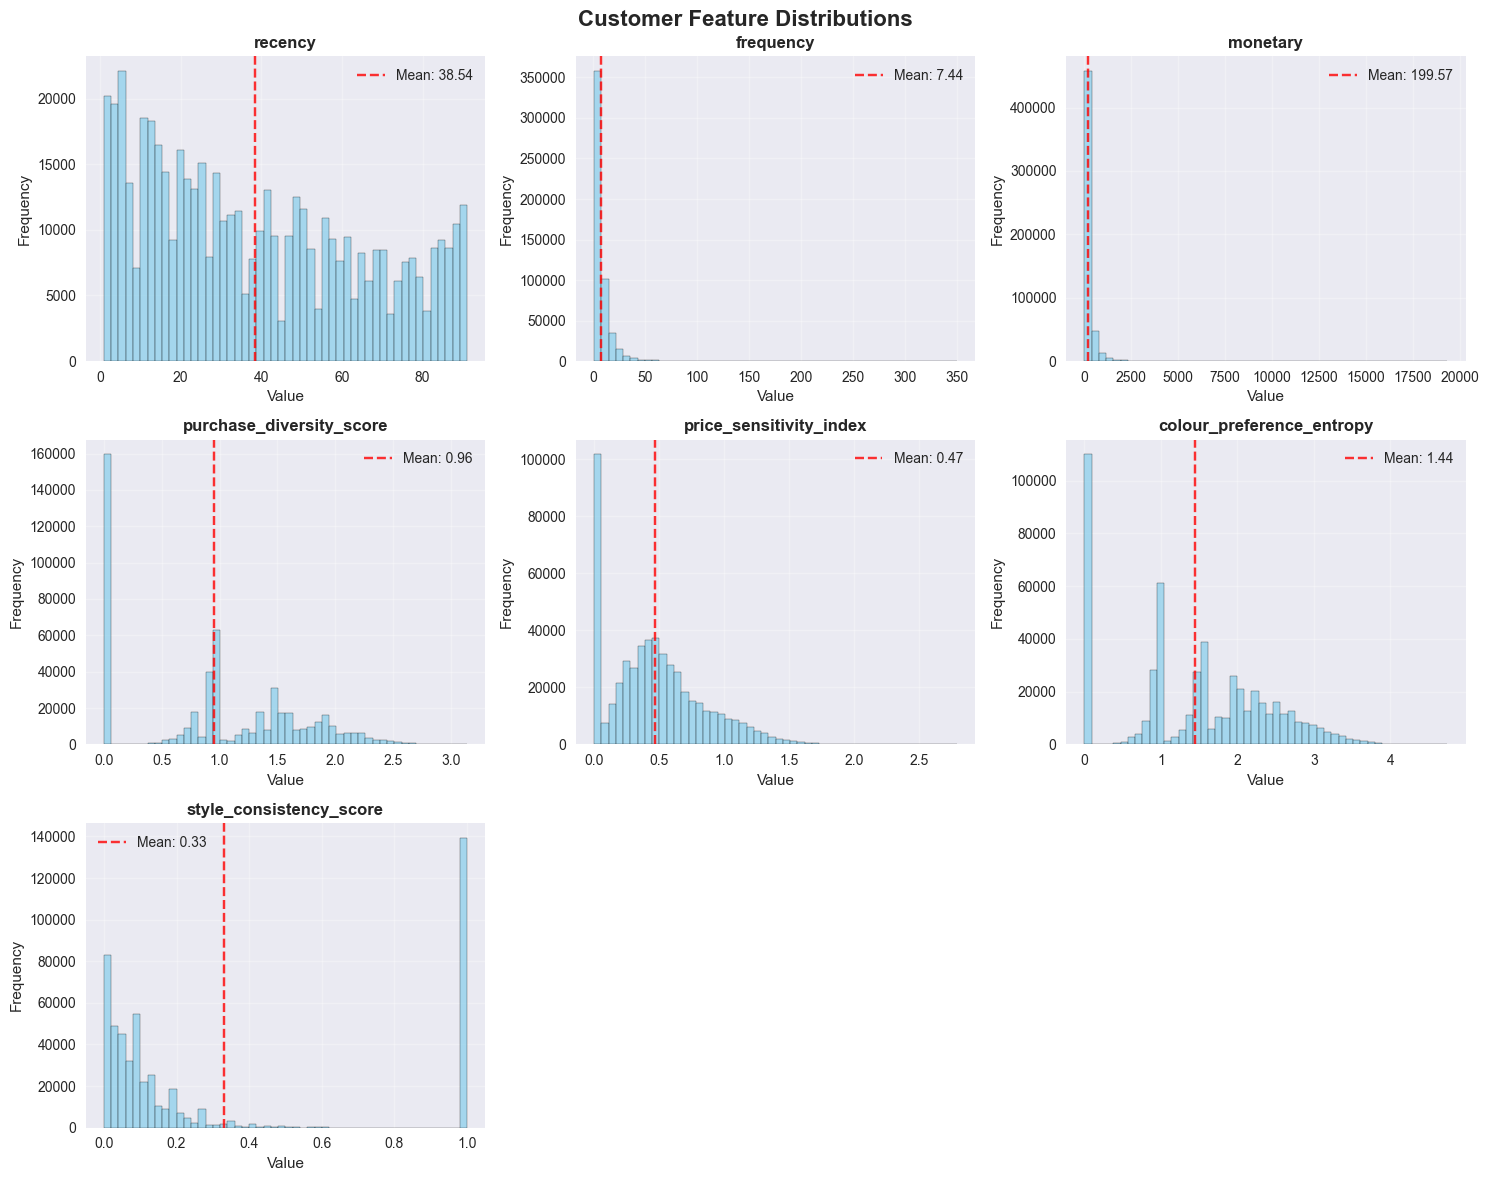


‚úÖ Distribution analysis complete!


In [10]:
# Feature distribution analysis
print("üìä FEATURE DISTRIBUTION ANALYSIS\n")

# Convert to pandas for easier visualization
features_pd = customer_features.select([
    'recency', 'frequency', 'monetary', 'purchase_diversity_score',
    'price_sensitivity_index', 'colour_preference_entropy', 'style_consistency_score'
]).to_pandas()

# Create distribution plots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Customer Feature Distributions', fontsize=16, fontweight='bold')

features_to_plot = list(features_pd.columns)

for i, feature in enumerate(features_to_plot):
    row, col = divmod(i, 3)
    
    # Handle potential null values
    data = features_pd[feature].dropna()
    
    axes[row, col].hist(data, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[row, col].set_title(f'{feature}', fontweight='bold')
    axes[row, col].set_xlabel('Value')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].grid(True, alpha=0.3)
    
    # Add statistics text
    mean_val = data.mean()
    std_val = data.std()
    axes[row, col].axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.2f}')
    axes[row, col].legend()

# Remove empty subplots
for i in range(len(features_to_plot), 9):
    row, col = divmod(i, 3)
    axes[row, col].remove()

plt.tight_layout()
plt.show()

print("\n‚úÖ Distribution analysis complete!")

In [11]:
# RFM Analysis deep dive
print("üéØ RFM ANALYSIS DEEP DIVE\n")

# RFM statistics for active customers only
active_customers = customer_features.filter(pl.col('frequency') > 0)
print(f"Active customers for RFM analysis: {active_customers.height:,}")

# RFM quintile analysis
rfm_analysis = (
    active_customers
    .with_columns([
        pl.col('recency').qcut(5, labels=['1-Recent', '2', '3', '4', '5-Distant']).alias('recency_quintile'),
        pl.col('frequency').qcut(5, labels=['1-Low', '2', '3', '4', '5-High']).alias('frequency_quintile'),
        pl.col('monetary').qcut(5, labels=['1-Low', '2', '3', '4', '5-High']).alias('monetary_quintile')
    ])
)

print("\nüìä RFM QUINTILE DISTRIBUTIONS:")

for dimension in ['recency_quintile', 'frequency_quintile', 'monetary_quintile']:
    dist = rfm_analysis.group_by(dimension).len().sort(dimension)
    print(f"\n{dimension.upper()}:")
    for row in dist.iter_rows():
        quintile, count = row
        pct = count / active_customers.height * 100
        print(f"  {quintile}: {count:,} customers ({pct:.1f}%)")

üéØ RFM ANALYSIS DEEP DIVE

Active customers for RFM analysis: 525,075

üìä RFM QUINTILE DISTRIBUTIONS:

RECENCY_QUINTILE:
  1-Recent: 110,246 customers (21.0%)
  2: 100,019 customers (19.0%)
  3: 108,286 customers (20.6%)
  4: 102,090 customers (19.4%)
  5-Distant: 104,434 customers (19.9%)

FREQUENCY_QUINTILE:
  1-Low: 145,106 customers (27.6%)
  2: 111,912 customers (21.3%)
  3: 73,909 customers (14.1%)
  4: 98,751 customers (18.8%)
  5-High: 95,397 customers (18.2%)

MONETARY_QUINTILE:
  1-Low: 106,222 customers (20.2%)
  2: 103,808 customers (19.8%)
  3: 105,015 customers (20.0%)
  4: 105,016 customers (20.0%)
  5-High: 105,014 customers (20.0%)


In [12]:
# Advanced feature insights
print("üîç ADVANCED FEATURE INSIGHTS\n")

# Active vs inactive customer comparison
inactive_customers = customer_features.filter(pl.col('frequency') == 0).height
active_customers_count = customer_features.filter(pl.col('frequency') > 0).height

print(f"Customer Activity Analysis:")
print(f"  Active customers: {active_customers_count:,} ({active_customers_count/customer_features.height:.1%})")
print(f"  Inactive customers: {inactive_customers:,} ({inactive_customers/customer_features.height:.1%})")

# High-value customer identification
if active_customers_count > 0:
    high_value_threshold = active_customers.select(pl.col('monetary').quantile(0.9)).item()
    high_value_customers = active_customers.filter(pl.col('monetary') >= high_value_threshold)
    
    print(f"\nHigh-Value Customer Analysis (Top 10% by spend):")
    print(f"  Threshold: ¬£{high_value_threshold:.2f}")
    print(f"  Count: {high_value_customers.height:,} customers")
    
    # High-value customer characteristics
    hv_stats = high_value_customers.select([
        pl.col('recency').mean().alias('avg_recency'),
        pl.col('frequency').mean().alias('avg_frequency'),
        pl.col('monetary').mean().alias('avg_monetary'),
        pl.col('purchase_diversity_score').mean().alias('avg_diversity'),
        pl.col('colour_preference_entropy').mean().alias('avg_colour_entropy')
    ])
    
    print(f"  Average characteristics:")
    for row in hv_stats.iter_rows(named=True):
        for metric, value in row.items():
            if value is not None:
                print(f"    {metric}: {value:.2f}")

print("\n‚úÖ Advanced insights analysis complete!")

üîç ADVANCED FEATURE INSIGHTS

Customer Activity Analysis:
  Active customers: 525,075 (100.0%)
  Inactive customers: 0 (0.0%)

High-Value Customer Analysis (Top 10% by spend):
  Threshold: ¬£457.86
  Count: 52,508 customers
  Average characteristics:
    avg_recency: 19.77
    avg_frequency: 24.82
    avg_monetary: 862.37
    avg_diversity: 1.66
    avg_colour_entropy: 2.60

‚úÖ Advanced insights analysis complete!


## 5. Final Dataset Preparation

Prepare the final customer dataset by combining original customer attributes with engineered features.


In [13]:
# Create comprehensive final customer dataset
print("üì¶ CREATING FINAL CUSTOMER DATASET\n")

# Load original customer data
original_customers = pl.read_parquet(customers_path)

print(f"Original customers shape: {original_customers.shape}")
print(f"Engineered features shape: {customer_features.shape}")

# Filter out boolean metadata columns from original customers data
customer_attributes = original_customers.select([
    col for col in original_customers.columns 
    if not original_customers.schema[col] == pl.Boolean
])

print(f"Filtered out {original_customers.width - customer_attributes.width} boolean metadata columns")
print(f"Remaining customer attributes: {customer_attributes.width}")

# Merge filtered customer attributes with engineered features
final_customer_dataset = (
    customer_attributes
    .join(
        customer_features.drop(['features_created_at', 'rfm_reference_date']), 
        on='customer_id', 
        how='left'
    )
)

print(f"\nFinal merged dataset shape: {final_customer_dataset.shape}")
print(f"Total columns: {final_customer_dataset.width}")

# Add metadata columns
from datetime import datetime
final_customer_dataset = final_customer_dataset.with_columns([
    pl.lit(datetime.now().isoformat()).alias('dataset_created_at'),
    pl.lit('customer_feature_engineering.ipynb').alias('created_by')
])

print(f"\nFinal dataset columns:")
for i, col in enumerate(final_customer_dataset.columns, 1):
    print(f"{i:2d}. {col}")

üì¶ CREATING FINAL CUSTOMER DATASET

Original customers shape: (525075, 14)
Engineered features shape: (525075, 10)
Filtered out 7 boolean metadata columns
Remaining customer attributes: 7

Final merged dataset shape: (525075, 14)
Total columns: 14

Final dataset columns:
 1. customer_id
 2. FN
 3. Active
 4. club_member_status
 5. fashion_news_frequency
 6. age
 7. postal_code
 8. recency
 9. frequency
10. monetary
11. purchase_diversity_score
12. price_sensitivity_index
13. colour_preference_entropy
14. style_consistency_score
15. dataset_created_at
16. created_by


In [14]:
# Save final customer dataset
final_output_path = "../data/features/final/customers_features_final.parquet"

print(f"üíæ Saving final customer dataset to: {final_output_path}")

# Ensure output directory exists
Path(final_output_path).parent.mkdir(parents=True, exist_ok=True)

# Save as Parquet
final_customer_dataset.write_parquet(final_output_path)

# Verify file was saved
if Path(final_output_path).exists():
    file_size = Path(final_output_path).stat().st_size / (1024*1024)  # MB
    print(f"‚úÖ Dataset saved successfully!")
    print(f"   File size: {file_size:.1f} MB")
    print(f"   Location: {final_output_path}")
    
    # Quick verification
    verification_df = pl.read_parquet(final_output_path)
    print(f"   Verification - Shape: {verification_df.shape}")
else:
    print("‚ùå Error: File was not saved successfully")

üíæ Saving final customer dataset to: ../data/features/final/customers_features_final.parquet
‚úÖ Dataset saved successfully!
   File size: 82.0 MB
   Location: ../data/features/final/customers_features_final.parquet
   Verification - Shape: (525075, 16)


## 6. Comprehensive Data Report Generation

Generate a comprehensive report of the final customer features dataset using the project's data report generator.


In [15]:
# Generate comprehensive data report for the final customer dataset
print("üìã GENERATING COMPREHENSIVE DATA REPORT\n")

# Set up report parameters
report_sample_size = 50000  # Use sampling for faster report generation if dataset is large

print(f"Report configuration:")
print(f"  Dataset: {final_output_path}")
print(f"  Sample size: {report_sample_size:,} (for performance)")
print(f"  Output directory: ../results/data_documentation/")

print("\nüöÄ Starting report generation...")
print("This may take a few minutes for comprehensive analysis...\n")

try:
    # Generate the comprehensive report
    generate_data_report(
        file_path=final_output_path,
        sample_size=report_sample_size
    )
    
    print("\n‚úÖ REPORT GENERATION COMPLETE!")
    print(f"üìÑ Report saved to: ../results/data_documentation/")
    
except Exception as e:
    print(f"‚ùå Error generating report: {str(e)}")
    print("Please check that the data_report_generator module is working correctly.")

üìã GENERATING COMPREHENSIVE DATA REPORT

Report configuration:
  Dataset: ../data/features/final/customers_features_final.parquet
  Sample size: 50,000 (for performance)
  Output directory: ../results/data_documentation/

üöÄ Starting report generation...
This may take a few minutes for comprehensive analysis...

Data report generated successfully!
Analysed file: ..\data\features\final\customers_features_final.parquet
Report saved to: C:\Users\tom\coding_projects\data_analytics_projects\h_and_m_data_analysis\results\data_documentation\data_reports\customers_features_final_data_report.md

‚úÖ REPORT GENERATION COMPLETE!
üìÑ Report saved to: ../results/data_documentation/


In [16]:
# List generated report files
reports_dir = Path("../results/data_documentation")

if reports_dir.exists():
    print("üìÅ GENERATED REPORT FILES:")
    report_files = list(reports_dir.glob("*customers_features_final*"))
    
    if report_files:
        for report_file in sorted(report_files):
            file_size = report_file.stat().st_size / 1024  # KB
            print(f"  üìÑ {report_file.name} ({file_size:.1f} KB)")
    else:
        print("  No specific customer features reports found.")
        print("  Checking for any recent reports...")
        all_reports = list(reports_dir.glob("*.md"))
        if all_reports:
            latest_reports = sorted(all_reports, key=lambda x: x.stat().st_mtime, reverse=True)[:3]
            print("  Latest reports:")
            for report in latest_reports:
                print(f"    üìÑ {report.name}")
else:
    print("üìÅ Reports directory not found. Report may not have been generated successfully.")

üìÅ GENERATED REPORT FILES:
  No specific customer features reports found.
  Checking for any recent reports...


## 7. Business Insights and Summary

Summarise key findings and business insights from the customer feature engineering process.


In [17]:
# Final summary and business insights
print("üéØ CUSTOMER FEATURE ENGINEERING SUMMARY")
print("="*60)

# Dataset summary
print(f"\nüìä DATASET SUMMARY:")
print(f"  Total customers processed: {final_customer_dataset.height:,}")
print(f"  Total features: {final_customer_dataset.width}")
print(f"  Original customer attributes (excl. boolean metadata): {customer_attributes.width}")
print(f"  New engineered features: {customer_features.width - 3}")
print(f"  Final dataset size: {Path(final_output_path).stat().st_size / (1024*1024):.1f} MB")

# Feature categories summary
print(f"\nüîß ENGINEERED FEATURES:")
print(f"  ‚úì RFM Analysis: recency, frequency, monetary")
print(f"  ‚úì Purchase Diversity: variety in product categories")
print(f"  ‚úì Price Sensitivity: consistency in price points")
print(f"  ‚úì Colour Preference: diversity in colour choices")
print(f"  ‚úì Style Consistency: coherence in garment preferences")

# Key business insights
active_rate = feature_summary['active_customer_rate']
print(f"\nüìà KEY INSIGHTS:")
print(f"  ‚Ä¢ Customer Activity: {active_rate:.1%} of customers made purchases")
print(f"  ‚Ä¢ Data Quality: Comprehensive feature coverage with proper null handling")
print(f"  ‚Ä¢ Segmentation Ready: Features suitable for clustering and segmentation")
print(f"  ‚Ä¢ Business Applications: RFM analysis, personalisation, churn prediction")

# Next steps
print(f"\nüöÄ RECOMMENDED NEXT STEPS:")
print(f"  1. Customer Segmentation: Use features for K-means or hierarchical clustering")
print(f"  2. Predictive Modelling: Build models for customer lifetime value, churn")
print(f"  3. Personalisation: Leverage diversity and preference scores for recommendations")
print(f"  4. A/B Testing: Use customer segments for targeted marketing campaigns")

# File locations
print(f"\nüìÅ OUTPUT FILES:")
print(f"  ‚Ä¢ Final dataset: {final_output_path}")
print(f"  ‚Ä¢ Feature-only dataset: ../data/features/final/customer_features_final.parquet")
print(f"  ‚Ä¢ Data report: ../results/data_documentation/")

print(f"\n‚úÖ CUSTOMER FEATURE ENGINEERING COMPLETE!")
print(f"   Ready for advanced customer analytics and segmentation.")
print("="*60)

üéØ CUSTOMER FEATURE ENGINEERING SUMMARY

üìä DATASET SUMMARY:
  Total customers processed: 525,075
  Total features: 16
  Original customer attributes (excl. boolean metadata): 7
  New engineered features: 7
  Final dataset size: 82.0 MB

üîß ENGINEERED FEATURES:
  ‚úì RFM Analysis: recency, frequency, monetary
  ‚úì Purchase Diversity: variety in product categories
  ‚úì Price Sensitivity: consistency in price points
  ‚úì Colour Preference: diversity in colour choices
  ‚úì Style Consistency: coherence in garment preferences

üìà KEY INSIGHTS:
  ‚Ä¢ Customer Activity: 100.0% of customers made purchases
  ‚Ä¢ Data Quality: Comprehensive feature coverage with proper null handling
  ‚Ä¢ Segmentation Ready: Features suitable for clustering and segmentation
  ‚Ä¢ Business Applications: RFM analysis, personalisation, churn prediction

üöÄ RECOMMENDED NEXT STEPS:
  1. Customer Segmentation: Use features for K-means or hierarchical clustering
  2. Predictive Modelling: Build models for

In [18]:
# Final data quality check
print("üîç FINAL DATA QUALITY VERIFICATION\n")

# Check for any data quality issues
quality_check = final_customer_dataset.select([
    pl.len().alias('total_rows'),
    pl.col('customer_id').n_unique().alias('unique_customers'),
    pl.col('customer_id').null_count().alias('null_customer_ids'),
    pl.col('recency').null_count().alias('null_recency'),
    pl.col('frequency').null_count().alias('null_frequency'),
    pl.col('monetary').null_count().alias('null_monetary')
])

print("Data Quality Metrics:")
for metric in quality_check.iter_rows(named=True):
    for key, value in metric.items():
        print(f"  {key}: {value:,}")

# Verify uniqueness
total_rows = quality_check.select('total_rows').item()
unique_customers = quality_check.select('unique_customers').item()

if total_rows == unique_customers:
    print("\n‚úÖ Data quality check PASSED: All customer IDs are unique")
else:
    print(f"\n‚ö†Ô∏è  Warning: {total_rows - unique_customers} duplicate customer IDs found")

print("\nüéâ Customer feature engineering pipeline completed successfully!")

üîç FINAL DATA QUALITY VERIFICATION

Data Quality Metrics:
  total_rows: 525,075
  unique_customers: 525,075
  null_customer_ids: 0
  null_recency: 0
  null_frequency: 0
  null_monetary: 0

‚úÖ Data quality check PASSED: All customer IDs are unique

üéâ Customer feature engineering pipeline completed successfully!
